In [1]:
import bisect
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interpolate
import seaborn as sns
from networkx.drawing.nx_pydot import graphviz_layout
import pydot

import dalmatian 

from helper import *
from gk_helper import *
from scipy.stats import iqr



# Specify inputs 

In [48]:
# Specify wbc and treatment files for growth kinetics 

patient = 'RP-1918_JB-0372'

wbc_file = 'data/JB_0372_wbc.txt'

# Load treatment file 
treatment = pd.read_csv("data/JB_0372_tx.txt", sep = '\t')


In [49]:
# Get input files from Terra through dalmatian

workspace ='broad-firecloud-ibmwatson/Brown_Getz_IBM_99-224_Exomes_Liang'
wm = dalmatian.WorkspaceManager(workspace)

participants = wm.get_participants()


cluster_CCF_df = pd.read_csv(participants.loc[patient]['cluster_ccfs'], sep='\t')
abundance_df = pd.read_csv(participants.loc[patient]['abundances_tsv'], sep='\t')
mcmc_df = pd.read_csv(participants.loc[patient]['cell_population_mcmc_trace'], sep='\t')
tree_df = pd.read_csv(participants.loc[patient]['tree_tsv'], sep='\t')

# Helper functions to parse the input files 

In [50]:
def load_wbc_file(file):
    """
    Parse wbc file

    Args:
        wbc file

    Returns:
        variables as a list

    """

    df = pd.read_csv(file, sep='\t')

    # Get all time points
    times = df.dfd.tolist()

    # Get times that are in the interpolation range
    t = pd.notna(df['sample_id'])
    sample_time_index = [i for i, x in enumerate(t) if x]
    first_sample_index = sample_time_index[0]
    last_sample_index = sample_time_index[-1]
    df_interpolate = df.iloc[first_sample_index:last_sample_index + 1, :]
    times_interpolate = df_interpolate.dfd.tolist()
    wbc_interpolate = df_interpolate.wbc.tolist()

    # Get all wbc points
    wbc = df.wbc.tolist()

    # Get the sample list
    sample_list = df.sample_id[pd.notna(df.sample_id)].tolist()

    # Get the times at sample points
    times_sample = df.dfd[pd.notna(df.sample_id)].tolist()

    # Get the wbc at sample points
    wbc_sample = df.wbc[pd.notna(df.sample_id)].tolist()

    # Get the times that are not at sample points
    times_others = sorted(list(set(times) - set(times_sample)))

    return times_sample, times, times_interpolate, wbc, wbc_interpolate, sample_list, wbc_sample, times_others


In [51]:
times_sample, times, times_interpolate, wbc, wbc_interpolate, sample_list, wbc_sample, times_others = load_wbc_file(wbc_file)

In [52]:
times_sample

[2615, 2699, 2951, 3119, 3287, 3455, 3616, 3784, 3952, 3998, 4027, 4090]

In [70]:
treatment = treatment[3:]

In [71]:
treatment

,tx,tx_start,tx_end
3,Acalabrutinib,2615,3996.0
4,Vecabrutinib (SNS-062),3998,4102.0
5,Venetoclax,4104,NaN


In [54]:
def interpolate_abundance(abundance, mcmc, mode="interpolate_only"):
    """
    Parse abundance file and get abundance information and calculate interpolated abundance

    Args:
        cell_population_abundance file and mcmc_trace file
        mode: "interpolate_only" or "extrapolate"

    Returns:
        lists

    """

    cluster_map = {}

    # Get the cluster list from the mcmc file
    cluster_list = mcmc.Cluster_ID.unique().tolist()

    # Map the abundacne to each cluster in a dictionary
    for cluster_id in cluster_list:
        abundance['cluster'] = abundance['Cell_population'].str.split('_').str[-1].str[2:].astype(int)

        cluster_map[cluster_id] = abundance[abundance.cluster == cluster_id]

    ## To get abundance information from the cell_population_abundances.tsv
    cluster_abundance = {}
    for cluster_id, abundances in cluster_map.items():
        cluster_abundances = []
        ## iterate through the samples in the wbc file to make sure the order is correct
        for sample_name in sample_list:
            sample_abundances = float(abundances[abundances.Sample_ID == sample_name].Cell_abundance)
            cluster_abundances.append(sample_abundances / 100)
        cluster_abundance[cluster_id] = cluster_abundances

    ## To calculate interpolated abundance
    inter_abundance = {}
    for cluster_id, abundance in cluster_abundance.items():
        abundance_first = abundance[0]
        abundance_last = abundance[-1]
        if mode == "extrapolate":
            interpolate_func = interpolate.interp1d(times_sample, abundance, bounds_error=False,
                                                    fill_value=(abundance_first, abundance_last))
            abundance_interpolate = interpolate_func(times)

        if mode == "interpolate_only":
            interpolate_func = interpolate.interp1d(times_sample, abundance)

            abundance_interpolate = interpolate_func(times_interpolate)

        inter_abundance[cluster_id] = list(abundance_interpolate)

    return cluster_list, cluster_abundance, inter_abundance

In [55]:
cluster_list, cluster_abundance, inter_abundance = interpolate_abundance(abundance_df, mcmc_df)

In [56]:
def calc_subclone(wbc, inter_abundance, cluster_list, mode = "default" , input_type = "default"):
    
    """
    Calculate subclone abundance from interpolated abundance

    Args:
        wbc and inter_abundance
        mode: "default" or "positive (ensure positivity after taking the log)"
        input type: "default" or "mcmc (contains values of all iterations)"
    Returns:
        dictionaries

    """
    
    subclone_population = {}
    log_subclone ={}
    log_subclone_raw ={}
    
    if input_type == "default":
        for cluster_id in cluster_list:
            subclone_population[cluster_id] = [_wbc*(abundance+1e-4) for _wbc, abundance in zip(wbc, inter_abundance[cluster_id])]
            if mode == "default":
                log_subclone[cluster_id] = [np.log(item) for item in subclone_population[cluster_id]]

                log_subclone_raw[cluster_id] = [np.log(item*1000) for item in subclone_population[cluster_id]] 

            if mode == "positive":
                log_subclone[cluster_id] = [0 if item <1 else np.log(item) for item in subclone_population[cluster_id]]

                log_subclone_raw[cluster_id] = [ 0 if item <1 else np.log(item*1000) for item in subclone_population[cluster_id]]

    if input_type == "mcmc":
        for cluster_id in cluster_list:
         
            subclone_population_per_iter = {}
            log_subclone_per_iter = {}
            log_subclone_raw_per_iter = {}
            
            for iter_idx in range(250):
                
                subclone_population_per_iter[iter_idx] = [_wbc*(abundance+1e-4) for _wbc, abundance in zip(wbc, inter_abundance[cluster_id][iter_idx])]
                if mode == "default":
                    log_subclone_per_iter[iter_idx] = [np.log(item) for item in subclone_population_per_iter[iter_idx]]

                    log_subclone_raw_per_iter[iter_idx] = [np.log(item*1000) for item in subclone_population_per_iter[iter_idx]] 

                if mode == "positive":
                    log_subclone_per_iter[iter_idx] = [0 if item <1 else np.log(item) for item in subclone_population_per_iter[iter_idx]]

                    log_subclone_raw_per_iter[iter_idx] = [ 0 if item <1 else np.log(item*1000) for item in subclone_population_per_iter[iter_idx]]

            subclone_population[cluster_id] = subclone_population_per_iter
            log_subclone[cluster_id] = log_subclone_per_iter
            log_subclone_raw[cluster_id] = log_subclone_raw_per_iter
                
    return subclone_population, log_subclone, log_subclone_raw

In [57]:
subclone_population, log_subclone, log_subclone_raw = calc_subclone(wbc_interpolate, inter_abundance, cluster_list, mode = "positive")

In [58]:
def get_all_abundance(cluster_list, mcmc_df, sample_list, times_sample, times_interpolate):
    
    """
    Get cell abundance and interpolated cell abundance from all mcmc iterations

    Args:
        cluster_list, mcmc_df, sample_list
    Returns:
        a dictionary with key: cluster and value: 250 iterations of cell abundance

    """
    all_abundance = {}
    interpolated_all_abundance = {}
    for cluster in cluster_list:

        abundance_per_iter ={}
        inter_abundance_per_iter = {}
        for iter_idx in range(250):

            df_mcmc_iter_clust = mcmc_df[(mcmc_df.Iteration == iter_idx) & (mcmc_df.Cluster_ID == cluster) ]

            cluster_abundances = []
            ## iterate through the samples in the wbc file to make sure the order is correct
            for sample_name in sample_list:
                sample_abundance = float(df_mcmc_iter_clust[df_mcmc_iter_clust.Sample_ID == sample_name].Abundance)
                cluster_abundances.append(sample_abundance / 100)

            abundance_per_iter[iter_idx] = cluster_abundances
            
            # get interpolated abundance 
            
            interpolate_func = interpolate.interp1d(times_sample, cluster_abundances)
            abundance_interpolate = interpolate_func(times_interpolate)
            
            inter_abundance_per_iter[iter_idx] = abundance_interpolate
            
        all_abundance[cluster] = abundance_per_iter
        interpolated_all_abundance[cluster] = inter_abundance_per_iter
        
    return all_abundance, interpolated_all_abundance

In [59]:
all_abundance, interpolated_all_abundance = get_all_abundance(cluster_list, mcmc_df, sample_list, times_sample, times_interpolate)

In [33]:
interpolated_all_abundance

{1: {0: array([0.01      , 0.01583333, 0.02166667, 0.0275    , 0.03333333,
         0.045     , 0.05666667, 0.08      , 0.07174603, 0.06444444,
         0.05333333, 0.02666667, 0.        , 0.005     , 0.01      ,
         0.005     , 0.        , 0.02      , 0.04      , 0.        ,
         0.        , 0.        , 0.05478261, 0.09      ]),
  1: array([ 0.00000000e+00,  5.00000000e-03,  1.00000000e-02,  1.50000000e-02,
          2.00000000e-02,  3.00000000e-02,  4.00000000e-02,  6.00000000e-02,
          5.38095238e-02,  4.83333333e-02,  4.00000000e-02,  2.00000000e-02,
          0.00000000e+00,  3.50000000e-02,  7.00000000e-02,  3.50000000e-02,
          0.00000000e+00,  3.50000000e-02,  7.00000000e-02,  3.00000000e-02,
          9.00000000e-02, -1.38777878e-17,  6.69565217e-02,  1.10000000e-01]),
  2: array([ 0.00000000e+00,  8.33333333e-03,  1.66666667e-02,  2.50000000e-02,
          3.33333333e-02,  5.00000000e-02,  6.66666667e-02,  1.00000000e-01,
          8.96825397e-02,  8.055555

In [131]:
def check_abundance_sum(all_abundance):
    sum = [0] * len(times_interpolate)
    for cluster in all_abundance:
        for i in range(len(times_interpolate)):
            fraction = all_abundance[cluster][240][i]
            sum[i] += fraction
    return sum

In [60]:
all_subclone_population, all_log_subclone, all_log_subclone_raw = calc_subclone(wbc_interpolate, interpolated_all_abundance, cluster_list, mode = "positive" , input_type = "mcmc")

# Helper functions to plot tree and CCF

In [244]:
tree_df

,n_iter,likelihood,edges
0,207,"[0.49999999999999906, 0.3333333333333341, 0.49...","1-2,1-3,2-4,2-5,3-7,3-8,4-6,6-9,None-1"
1,152,"[0.24999999999999906, 0.49999999999999906, 0.4...","1-2,1-3,1-9,2-4,2-5,3-7,3-8,4-6,None-1"
2,140,"[0.3333333333333341, 0.49999999999999906, 0.49...","1-2,1-3,2-4,2-5,3-7,3-8,4-6,4-9,None-1"


In [245]:
def plot_tree(tree_df, tree_selected, ax, edge_labels =None):
    edges = tree_df.loc[tree_selected, 'edges'].split(',')
    cluster_list = []
    for i in edges:
        new_list = i.split('-')
        for j in new_list:
            if (j !='None') & (j not in cluster_list):

                cluster_list.append(j)
    cluster_list = [int(i) for i in cluster_list]
    
    
    DG=nx.DiGraph() 
    for edge in edges:
        nodes = edge.split('-')
        if nodes[0]!='None':
            DG.add_edge(int(nodes[0]), int(nodes[1]))
            
    pos=graphviz_layout(DG,  prog='dot')
    
    edge_color_list=[]
    for edge in DG.edges():
        node=edge[1]

        edge_color_list.append(ClusterColors.get_hex_string(node) )
        
    nx.draw(DG,pos, with_labels = True, width = 4, node_size= 400, ax =ax, arrows= False, font_color='white',edge_color = edge_color_list, node_color =[ClusterColors.get_hex_string(i) for i in cluster_list] )
    if edge_labels:
        nx.draw_networkx_edge_labels(DG, pos,
        edge_labels,
        font_color=ClusterColors.get_hex_string(7))

    return DG

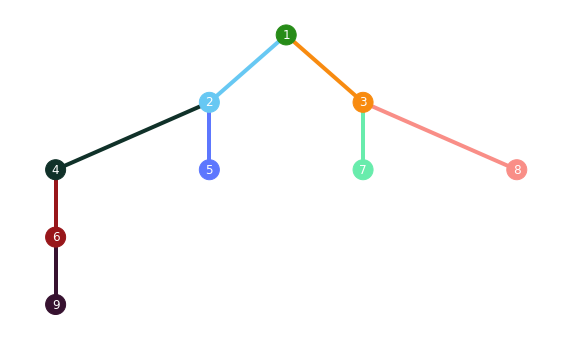

In [247]:
fig, ax = plt.subplots(figsize = (10, 6))
plot_tree(tree_df, tree_selected =0,ax = ax, )

In [72]:
def plot_ccf(df, ax, times_sample, color_map):
    # Keep the necessary columns 
    cols = ['Sample_ID','Cluster_ID','postDP_ccf_mean','postDP_ccf_CI_low','postDP_ccf_CI_high' ]
    df = df[cols]
    cluster_list = df.Cluster_ID.unique().tolist()
    number_samples = len(df.Sample_ID.unique())
    
    tick_list = ['T'+ str(i) for i in range(number_samples)] 
    x_axis = [i/365 for i in times_sample]
    ax.set_xticks(x_axis)

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel("Time (years)")
    ax.grid(True)

    

    for i in cluster_list:
        x = df[df.Cluster_ID == i].Sample_ID
        y = df[df.Cluster_ID == i].postDP_ccf_mean

        ci_low = df[df.Cluster_ID == i].postDP_ccf_CI_low
        ci_high = df[df.Cluster_ID == i].postDP_ccf_CI_high
        

        ax.plot(x_axis, y,c= ClusterColors.get_hex_string(i), marker ='o', label = i)
    
        ax.fill_between(x_axis, ci_low, ci_high, color= ClusterColors.get_hex_string(i), alpha = 0.1)
        
        
        ax.set_xlabel('Samples')
        ax.set_xticks(x_axis)

        ax.set_xticklabels(tick_list, fontsize =8)

        ax.set_ylabel('CCF')
        ax.legend()
        
    cmap = plt.get_cmap(color_map)
    xlim = ax.get_xlim()[1]
    for i, row in treatment.iterrows():
        treatment_name = row.tx
        start = row.tx_start/365
        end = row.tx_end/365
        if np.isnan(end):
            end = xlim
        length = end - start 
        center = (start + end)/2

        ax.axvspan(xmin = start, xmax= end,  facecolor= cmap(i), alpha = 0.2)



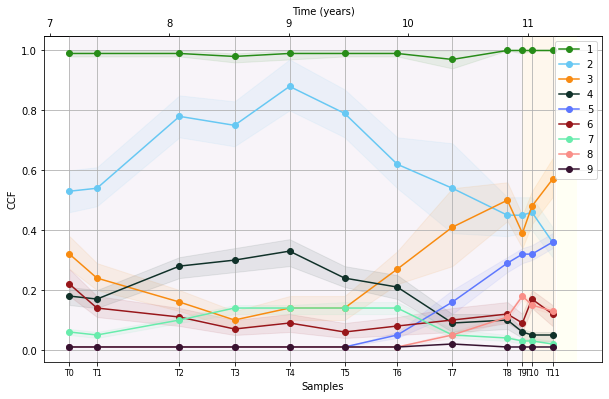

In [73]:
fig, ax = plt.subplots(figsize = (10, 6))
plot_ccf(cluster_CCF_df,ax, times_sample , color_map = "Pastel1")

# PWLF exploration

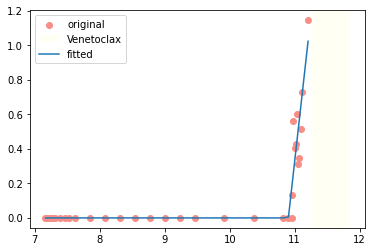

In [67]:
import pwlf
import math

# fit for specified number of line segments 
subclones = [8]
num_seg = 2

for i in subclones:
    x = [ i/365 for i in np.array(times_interpolate)]
    y = np.array(log_subclone[i])
    myPWLF = pwlf.PiecewiseLinFit(x, y)

    z = myPWLF.fit(num_seg)

#     calculate slopes
    slopes = myPWLF.calc_slopes()

#     predict for the determined points
    xHat = x
    yHat = myPWLF.predict(xHat)

    #calculate statistics
    p = myPWLF.p_values(method='non-linear', step_size=1e-4) #p-values
    se = myPWLF.se  # standard errors
plt.scatter(x, y,c= ClusterColors.get_hex_string(i),label = 'original')

cmap = plt.get_cmap("Pastel1")
xlim = ax.get_xlim()[1]

for i, row in treatment.iterrows():
    treatment_name = row.tx
    start = row.tx_start/365
    end = row.tx_end/365
    if np.isnan(end):
        end = xlim
    length = end - start 
    center = (start + end)/2
plt.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
# plt.set_xlabel('Samples')
plt.plot(xHat, yHat,'-', label = 'fitted')
plt.legend()

In [171]:
slopes

array([-8.32822986e+00, -1.05793470e-07,  4.48591849e+00, -4.71321880e+01,
        8.36973502e-01])

## For all mcmc iterations

4.493238487116385
4.36540027290461
4.4255961316602335
4.504237955350694
4.547056922724247
4.42944907203822
4.451651820706368
4.482063674404001
4.389887190212424
4.382014113494473
4.425593632092366
4.425592319409769
4.42198247538492
4.504656199710968
4.526177443424935
4.410861258055405
4.498332293613523
4.470261682882356
4.459704653259976
4.41475595729224
4.470768266020241
4.508131951557194
4.533771482238795
4.470261478379962
4.504247726251957
4.443923038599476
4.444365209767913
4.485919271007402
4.425591506088582
4.399994676455049
4.521036576385878
4.414754970480876
4.433443747002298
4.478452209134817
4.323638696011061
4.522856209474057
4.698516001732254
4.440607186242456
4.53603756703873
4.4330669494280315
4.4816808407987
4.54877866292519
4.496982546453387
4.444415294549567
4.5210775254785425
4.531818597068934
4.458456406066505
4.3961601165849515
4.474215082018238
4.410861766437381
4.426165765741824
4.4332616139583445
4.489732558782737
4.508130145520191
4.439995554094586
4.43637516874

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


4.5931341270960475


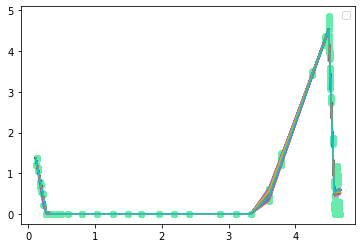

In [238]:
import pwlf
import math

# fit for specified number of line segments 
subclones = [7]
num_seg = 5

for i in subclones:
    x = [ i/365 for i in np.array(times_interpolate)]
    
    all_slopes = []
    for iter_idx in range(250):
        
        
        y = np.array(all_log_subclone[i][iter_idx])
        myPWLF = pwlf.PiecewiseLinFit(x, y)

        z = myPWLF.fit(num_seg)

        #calculate slopes
        slopes = myPWLF.calc_slopes()
        
        seg_slope = slopes[2]

        all_slopes.append(seg_slope)
        # predict for the determined points
        xHat = x
        yHat = myPWLF.predict(xHat)

        #calculate statistics
        p = myPWLF.p_values(method='non-linear', step_size=1e-4) #p-values
        se = myPWLF.se  # standard errors
        plt.scatter(x, y,c= ClusterColors.get_hex_string(i))
        plt.plot(xHat, yHat,'-')
        
plt.legend()

In [242]:
lower_ci = np.percentile(all_slopes, 2.5, axis=0)
upper_ci = np.percentile(all_slopes, 97.5, axis=0)
mean = np.mean(all_slopes)

In [243]:
lower_ci, mean, upper_ci

(4.36678769204442, 4.474755181866092, 4.659291046199544)

# PWLF plotting 

In [266]:
import pwlf


def pwlf_fitting (ax, subclones, num_seg):

    x = [ i/365 for i in np.array(times_interpolate)]
    for i in subclones:
    
        for iter_idx in range(250):
            y = np.array(all_log_subclone[i][iter_idx])
            myPWLF = pwlf.PiecewiseLinFit(x, y)

            z = myPWLF.fit(num_seg)

            #calculate slopes
            slopes= myPWLF.calc_slopes()


            # predict for the determined points
            xHat = x
            yHat = myPWLF.predict(xHat)

            ax.scatter(x, y,c= ClusterColors.get_hex_string(i))
            ax.plot(xHat, yHat,'-')
            
            title_text = f'Cluster {i}'

        # plot total wbc

        x_year = [ i/365 for i in np.array(times_interpolate)]
        ax.scatter(x_year,np.log(wbc_interpolate), label = 'Total WBC', c = 'red')

        x_axis = [i/365 for i in times_sample]
        ax.set_xticks(x_axis)

        secax = ax.secondary_xaxis('top')
        secax.set_xlabel("Time (years)")
        ax.grid(True)


        ax.set_title(title_text)

        ax.set_xticklabels(tick_list, fontsize =8)
        ax.set_ylabel(r"log(WBC $\times 10^6$ cells per ml)")



        cmap = plt.get_cmap("Pastel1")
        xlim = ax.get_xlim()[1]

        for i, row in treatment.iterrows():
            treatment_name = row.tx
            start = row.tx_start/365
            end = row.tx_end/365
            if np.isnan(end):
                end = xlim
            length = end - start 
            center = (start + end)/2
            ax.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
            ax.set_xlabel('Samples')


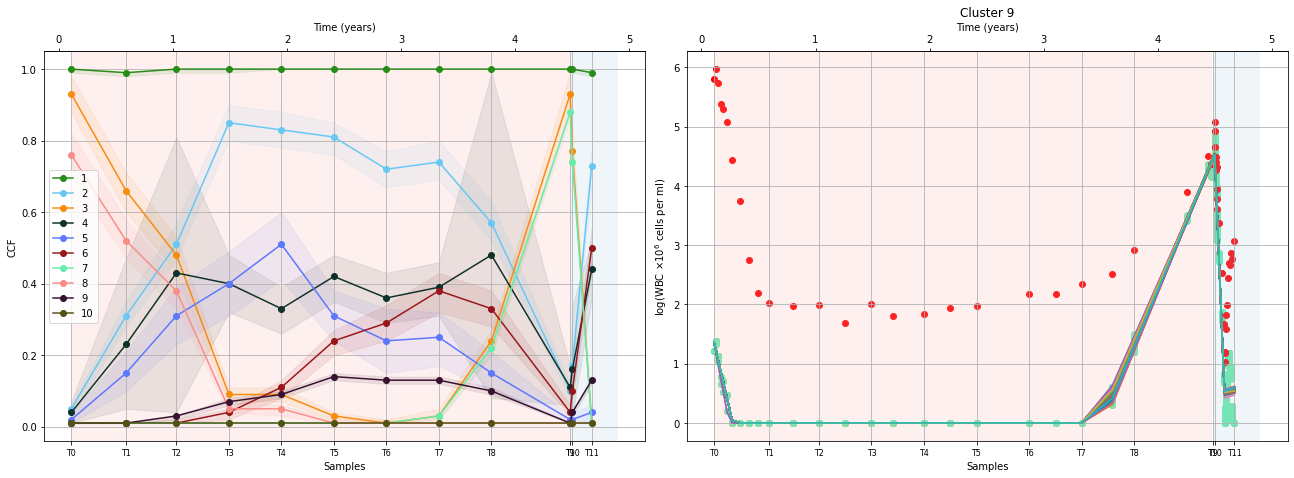

In [267]:
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(18,6))
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)

tick_num = len(sample_list)

tick_list = ['T'+ str(i) for i in range(tick_num)]

plot_ccf(cluster_CCF_df,ax1, times_sample, color_map = "Pastel1" )
pwlf_fitting(ax2, [7], 5)

In [36]:
def pwlf_fitting (subclones, num_seg):

    x = [ i/365 for i in np.array(times_interpolate)]
    y = np.array(log_subclone[subclones])
    myPWLF = pwlf.PiecewiseLinFit(x, y)

    z = myPWLF.fit(num_seg)

    #calculate slopes
    slopes= myPWLF.calc_slopes()


    # predict for the determined points
    xHat = x
    yHat = myPWLF.predict(xHat)

    #calculate statistics
    p = myPWLF.p_values(method='non-linear', step_size=1e-4) #p-values
    se = myPWLF.se  # standard errors
    
    return x, y,xHat, yHat, slopes

Slopes of the linear regression for cluster 5: [-1.94289029e-16  6.10170157e+01 -6.19506361e+00  6.98517609e+01
  3.67063710e+00]


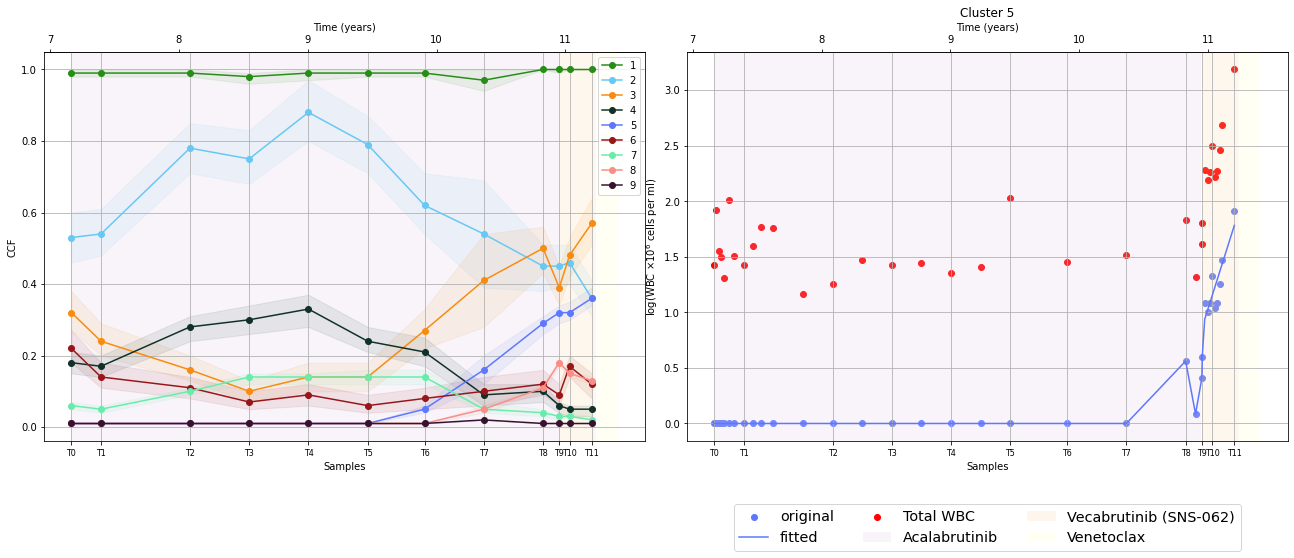

In [76]:

fig,(ax1, ax2) = plt.subplots(1,2, figsize=(18,6))
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)

tick_num = len(sample_list)

tick_list = ['T'+ str(i) for i in range(tick_num)]


def plot_exp(ax, cluster, num_seg):
    
    
    if isinstance(cluster, list):

    
        for cluster, num_seg in zip(cluster, num_seg):

            ax.scatter(pwlf_fitting(cluster, num_seg)[0], pwlf_fitting(cluster, num_seg)[1], c= ClusterColors.get_hex_string(cluster),label = f'Cluster {cluster} original')
            ax.plot(pwlf_fitting(cluster, num_seg)[2], pwlf_fitting(cluster, num_seg)[3],'-', c= ClusterColors.get_hex_string(cluster),label = f'Cluster {cluster} fitted')

        title_text = f'Combined'
            
    else:
        ax.scatter(pwlf_fitting(cluster, num_seg)[0], pwlf_fitting(cluster, num_seg)[1], c= ClusterColors.get_hex_string(cluster),label = 'original')
        ax.plot(pwlf_fitting(cluster, num_seg)[2], pwlf_fitting(cluster, num_seg)[3],'-', c= ClusterColors.get_hex_string(cluster),label = 'fitted')

        title_text = f'Cluster {cluster}'

        ax.legend()
        
        
    # plot total wbc
    
    x_year = [ i/365 for i in np.array(times_interpolate)]
    ax.scatter(x_year,np.log(wbc_interpolate), label = 'Total WBC', c = 'red')
    
    x_axis = [i/365 for i in times_sample]
    ax.set_xticks(x_axis)

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel("Time (years)")
    ax.grid(True)
    

    ax.set_title(title_text)
    
    ax.set_xticklabels(tick_list, fontsize =8)
    ax.set_ylabel(r"log(WBC $\times 10^6$ cells per ml)")
    
    
    
    cmap = plt.get_cmap("Pastel1")
    xlim = ax.get_xlim()[1]
    
    for i, row in treatment.iterrows():
        treatment_name = row.tx
        start = row.tx_start/365
        end = row.tx_end/365
        if np.isnan(end):
            end = xlim
        length = end - start 
        center = (start + end)/2
#         color = color_dict[treatment_name]
        ax.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
#         ax.legend(ncol = treatment.shape[0], loc='upper center', bbox_to_anchor=(0.5, -2), fontsize = 'x-large')
        ax.set_xlabel('Samples')

    
#     ax.legend(ncol = treatment.shape[0], loc='upper left',  fontsize = 'x-large')
    
    
    if not isinstance(cluster, list):
        # print slopes
        x, y,xHat, yHat, slopes = pwlf_fitting(cluster, num_seg)
        print (f'Slopes of the linear regression for cluster {cluster}: {slopes}')


plot_ccf(cluster_CCF_df,ax1, times_sample, color_map = "Pastel1" )
plot_exp(ax2, 5, 5)
ax2.legend(ncol = treatment.shape[0], loc='lower center',  bbox_to_anchor=(0.5, -0.3),fontsize = 'x-large')

# plot_exp(ax3, 4,3)

# plot_exp(ax4, [3,4],[8,3])

plt.savefig('JB-0373_GK.pdf', bbox_inches = "tight")